In [1]:
import numpy as np
import xarray as xr
import matplotlib.pylab as plt

In [2]:
from core_fct.mod_process import OSCAR
from core_fct.fct_loadP import load_all_param
from core_fct.fct_genMC import generate_config
from run_scripts.get_SSP_drivers import For_hist
from run_scripts.get_SSP_drivers import For_scen

loading primary parameters


In [3]:
from matplotlib.gridspec import GridSpec

## historical模拟

In [4]:
Par0 = load_all_param(mod_region='RCP_5reg')
Par = generate_config(Par0, nMC=200)
Par = xr.merge([Par, For_hist.drop([VAR for VAR in For_hist if 'year' in For_hist[VAR].dims])])
For_hist = For_hist.drop([VAR for VAR in For_hist if 'year' not in For_hist[VAR].dims])

Out_hist = OSCAR(Ini=None, Par=Par, For=For_hist)

loading primary parameters
generating MC configurations
OSCAR_v3 running
year = 2014 (nt = 3)
total running time: 4.9 minutes


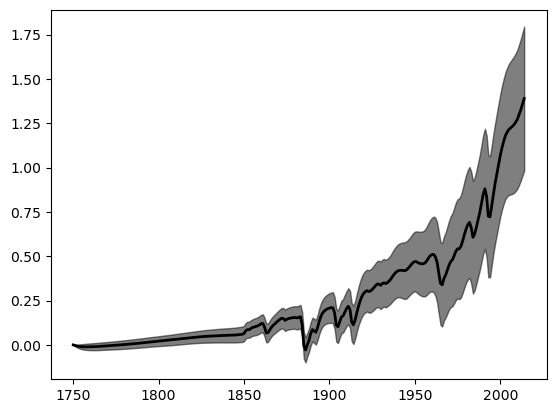

In [5]:
plt.plot(Out_hist.year, Out_hist.D_Tg.mean('config'), color='k', lw=2)
plt.fill_between(Out_hist.year, Out_hist.D_Tg.mean('config') - Out_hist.D_Tg.std('config'), Out_hist.D_Tg.mean('config') + Out_hist.D_Tg.std('config'), color='k', alpha=0.5)

## SSP情景模拟

In [6]:
For_scen = For_scen.sel(year=slice(None, 2100))
Ini = Out_hist.isel(year=-1, drop=True)
var_keep = ['D_Eluc', 'D_Focean', 'D_Fland', 'D_Epf'] + ['tau_CH4', 'tau_N2O'] + ['RF_CH4','RF_O3t']+['D_O3t']+['f_kOH_O3P']
Out_scen = OSCAR(Ini=Ini, Par=Par, For=For_scen, var_keep=var_keep, nt=4)
if False: Out_scen.to_netcdf('results/Out_scen_test.nc')

import matplotlib.pyplot as plt
def f_plot(VAR):
    plt.figure()
    if VAR in Out_hist:
        plt.plot(Out_hist.year, Out_hist[VAR].mean('config'), color='k', lw=2, label='hist')
        plt.fill_between(Out_hist.year, Out_hist[VAR].mean('config') - Out_hist[VAR].std('config'), 
            Out_hist[VAR].mean('config') + Out_hist[VAR].std('config'), color='k', alpha=0.5)
    for scen in Out_scen.scen.values:
        plt.plot(Out_scen.year, Out_scen[VAR].sel(scen=scen).mean('config'), lw=2, label=scen)
        plt.fill_between(Out_scen.year, Out_scen[VAR].sel(scen=scen).mean('config') - Out_scen[VAR].sel(scen=scen).std('config'), 
            Out_scen[VAR].sel(scen=scen).mean('config') + Out_scen[VAR].sel(scen=scen).std('config'), alpha=0.5)
    plt.title(VAR + ' (' + Out_scen[VAR].units + ')')


OSCAR_v3 running
year = 2100 (nt = 9)
total running time: 5.4 minutes


In [7]:
Ini = Out_hist.isel(year=-1, drop=True)
x2_OH_NOX = 0.00414
x2_OH_CO = -0.00024
x2_OH_VOC = -0.00027
Ini['D_CH4'] = 1822.61-Par0.CH4_0 # https://gml.noaa.gov/webdata/ccgg/trends/ch4/ch4_annmean_gl.txt

In [10]:
Par_tmp = Par.copy(deep=True)
For_scen_tmp = For_scen.sel(year=slice(None, 2050)).copy(deep=True).drop_vars('D_CH4')

In [11]:
Par_tmp.kOH_is_Log.values = np.array([False]*200)

Par_tmp.x2_OH_NOX.values = np.array([0.00414]*200)
Par_tmp.x2_OH_CO.values = np.array([-0.00024]*200)
Par_tmp.x2_OH_VOC.values = np.array(-0.00027)

In [12]:
Out_scen = OSCAR(Ini=Ini, Par=Par_tmp, For=For_scen.copy(deep=True).sel(year=slice(2014,2030)), var_keep=var_keep, nt=4)

OSCAR_v3 running
year = 2030 (nt = 4)
total running time: 0.7 minutes


In [14]:
# scen_list = ['SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0','SSP5-8.5']

# Plot_scen = Out_scen.sel(scen=scen_list)

# for scen in scen_list:
#     data = Plot_scen.D_CH4.sel(scen=scen)
#     plt.plot(Plot_scen.year,data.mean('config'))
#     plt.fill_between(Plot_scen.year,data.mean('config')-data.std('config'),data.mean('config')+data.std('config'),
#                     alpha=0.4)

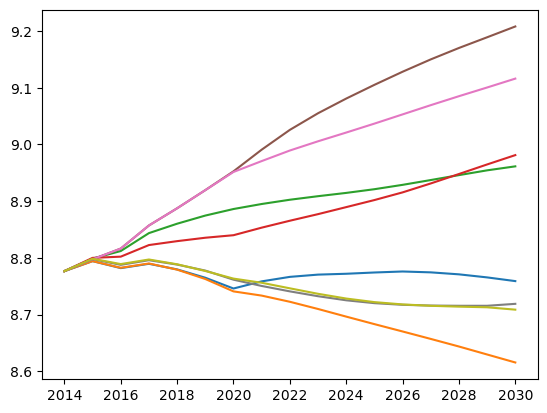

In [15]:
plt.plot(Out_scen.year,Out_scen.tau_CH4.mean('config'))

In [16]:
# 

In [17]:
temp = Out_scen['tau_CH4']/Out_scen['tau_CH4'].sel(year=2014)

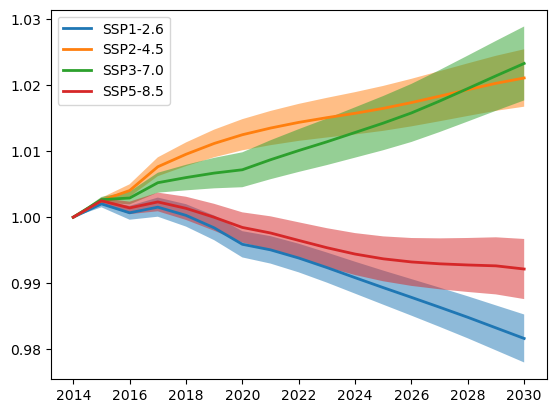

In [18]:
for scen in [ 'SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0','SSP5-8.5']:
    plt.plot(Out_scen.year, temp.mean('config').sel(scen=scen), lw=2, label=scen)
    plt.fill_between(Out_scen.year, temp.mean('config').sel(scen=scen) - temp.std('config').sel(scen=scen), 
        temp.mean('config').sel(scen=scen) + temp.std('config').sel(scen=scen), alpha=0.5)
plt.legend()

# 减排情景
SSP3-7.0  
SSP3-7.0-CH4m  
SSP3-7.0-O3Pm  
SSP3-7.0-CH4m-O3Pm  


In [19]:
scen_list = ['SSP3-7.0','SSP3-7.0-CH4m','SSP3-7.0-O3Pm','SSP3-7.0-CH4m-O3Pm']

In [20]:
temp = []
for scen in scen_list:
    temp.append(For_scen_tmp.sel(scen='SSP3-7.0').assign_coords(scen=np.array([scen])))
For_scen_exp = xr.concat(temp,dim='scen')

In [21]:
For_scen_exp = []

temp = For_scen_tmp.sel(scen='SSP3-7.0').assign_coords(scen=np.array(['SSP3-7.0']))
For_scen_exp.append(temp)

temp = For_scen_tmp.sel(scen='SSP3-7.0').assign_coords(scen=np.array(['SSP3-7.0-CH4m']))
temp['E_CH4'] = For_scen_tmp.sel(scen='SSP1-2.6').E_CH4
For_scen_exp.append(temp)

temp = For_scen_tmp.sel(scen='SSP3-7.0').assign_coords(scen=np.array(['SSP3-7.0-O3Pm']))
temp['E_NOX'] = For_scen_tmp.sel(scen='SSP1-2.6').E_NOX
temp['E_CO'] = For_scen_tmp.sel(scen='SSP1-2.6').E_CO
temp['E_VOC'] = For_scen_tmp.sel(scen='SSP1-2.6').E_VOC
For_scen_exp.append(temp)

temp = For_scen_tmp.sel(scen='SSP3-7.0').assign_coords(scen=np.array(['SSP3-7.0-CH4m-O3Pm']))
temp['E_CH4'] = For_scen_tmp.sel(scen='SSP1-2.6').E_CH4
temp['E_NOX'] = For_scen_tmp.sel(scen='SSP1-2.6').E_NOX
temp['E_CO'] = For_scen_tmp.sel(scen='SSP1-2.6').E_CO
temp['E_VOC'] = For_scen_tmp.sel(scen='SSP1-2.6').E_VOC
For_scen_exp.append(temp)


For_scen_exp = xr.concat(For_scen_exp,dim='scen')

In [22]:
Out_scen_exp = OSCAR(Ini=Ini, Par=Par_tmp, For=For_scen_exp, var_keep=var_keep, nt=4)

OSCAR_v3 running
year = 2050 (nt = 4)
total running time: 1.5 minutes


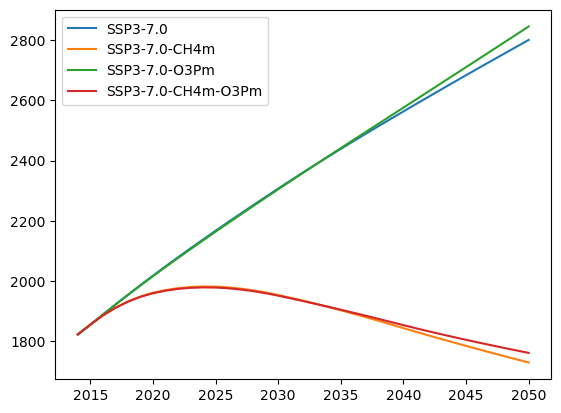

In [23]:
plt.plot(Out_scen_exp.year,Out_scen_exp.D_CH4.mean('config')+Par.CH4_0,label=Out_scen_exp.scen.values)
# plt.plot(Out_scen_exp.sel(year=slice(None, 2050)).year,Out_scen_exp.sel(year=slice(None, 2050)).D_CH4.sel(scen='SSP3-7.0')+Par.CH4_0)
plt.legend()

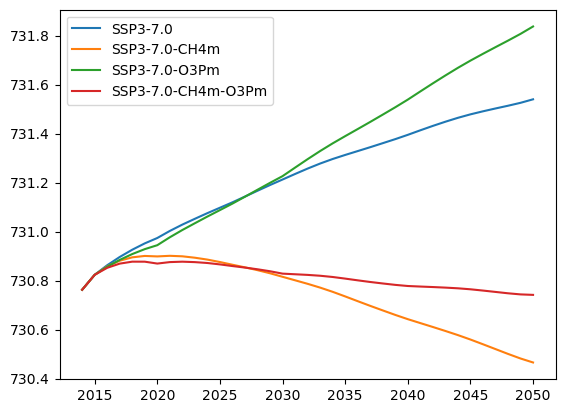

In [24]:
plt.plot(Out_scen_exp.year,Out_scen_exp.tau_CH4.mean('config')+Par.CH4_0,label=Out_scen_exp.scen.values)
plt.legend()

# 下一步修改的方向

1. 把2023年前的排放替换成CEDS的真实排放数据
2. 把甲烷大气浓度初始值（2014）替换成观测值
3. 通过头十年的模拟，确实合适的生命周期参数`t_OH_CH4`

In [25]:
## 生成三个排放情景

## 2014-2019 (CEDS)
CEDS_CH4 = [270.2496358,269.8280079,267.9817751,268.1138598,270.537411,271.6083044]
CEDS_NOX = [38.59678516,37.98745474,37.48333497,37.43483474,37.16926467,36.81225668]
CEDS_CO = [247.089963,241.5313653,233.9000087,230.9691292,228.7215534,226.6449276]
CEDS_VOC = [149.9870685,148.9745692,148.276486,148.5098291,147.521796,146.6675455]

For_scen_real = For_scen_tmp.copy(deep=True).sel(scen=['SSP2-4.5','SSP2-4.5','SSP2-4.5']).assign_coords(scen=np.array(['middle','clean','polluted']))
For_scen_real.E_CH4[0,6:] -= (For_scen_real.E_CH4.sel(year=2019).sum('reg_land').values-CEDS_CH4[-1])
for i in range(len(CEDS_CH4)):
    For_scen_real.E_CH4[:,i] *=0
    For_scen_real.E_CH4[0,i] +=CEDS_CH4[i]
for var in ['E_NOX','E_CO','E_VOC',]:
    For_scen_real[var][...,1] = For_scen_tmp[var].copy(deep=True).sel(scen='SSP1-1.9')
    For_scen_real[var][...,2] = For_scen_tmp[var].copy(deep=True).sel(scen='SSP3-7.0')
For_scen_real.E_NOX[0,6:] -= (For_scen_real.E_NOX.sel(year=2019).sum('reg_land').values-CEDS_NOX[-1])
For_scen_real.E_CO[0,6:] -= (For_scen_real.E_CO.sel(year=2019).sum('reg_land').values-CEDS_CO[-1])
For_scen_real.E_VOC[0,6:] -= (For_scen_real.E_VOC.sel(year=2019).sum('reg_land').values-CEDS_VOC[-1])

for i in range(len(CEDS_CH4)):
    For_scen_real.E_NOX[:,i] *=0
    For_scen_real.E_NOX[0,i] +=CEDS_NOX[i]
    For_scen_real.E_CO[:,i] *=0
    For_scen_real.E_CO[0,i] +=CEDS_CO[i]
    For_scen_real.E_VOC[:,i] *=0
    For_scen_real.E_VOC[0,i] +=CEDS_VOC[i]

In [26]:
Par_tmp['t_OH_CH4'] *= 0
Par_tmp['t_OH_CH4'] += 11.2

In [27]:
Out_scen_real = OSCAR(Ini=Ini, Par=Par_tmp, For=For_scen_real, var_keep=var_keep+['f_kOH','f_kOH_O3P', 'D_Ebb'], nt=4)

OSCAR_v3 running
year = 2050 (nt = 4)
total running time: 1.5 minutes


Text(0.5, 1.0, '$E_{NOX}$ (MtN)')

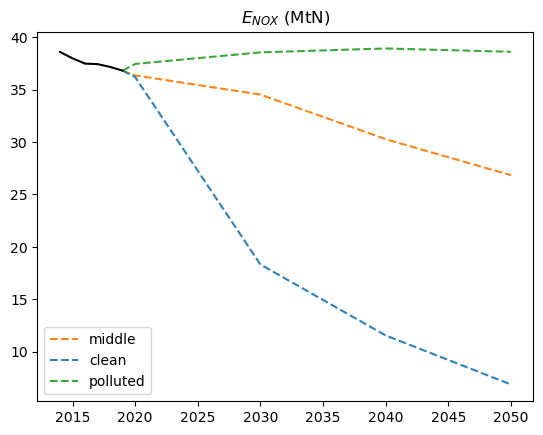

In [28]:
color_list = ['#FF8315','#2D82BA','#3BA73B']
for i in range(len(Out_scen_real.scen)):
    plt.plot(Out_scen_real.year.sel(year=slice(2019,2050)),For_scen_real.isel(scen=i).E_NOX.sel(year=slice(2019,2050)).sum('reg_land'),label=Out_scen_real.scen.values[i],
             linestyle='--',color=color_list[i])
plt.plot(Out_scen_real.year.sel(year=slice(2014,2019)),For_scen_real.isel(scen=i).E_NOX.sum('reg_land').sel(year=slice(2014,2019)),color='k')
plt.legend()
plt.title('$E_{NOX}$ (MtN)')

Text(0.5, 1.0, '$E_{CH_4}$ (Mt)')

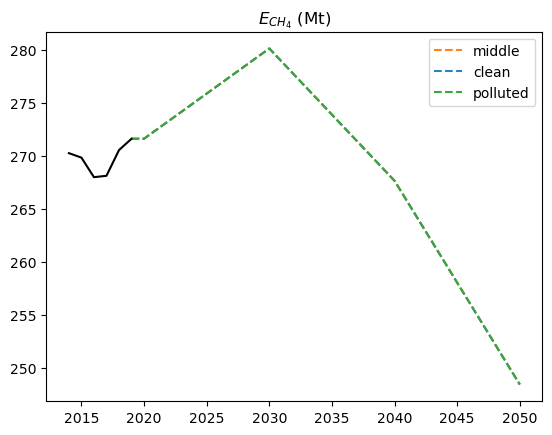

In [29]:
color_list = ['#FF8315','#2D82BA','#3BA73B']
for i in range(len(Out_scen_real.scen)):
    plt.plot(Out_scen_real.year.sel(year=slice(2019,2050)),For_scen_real.isel(scen=i).E_CH4.sel(year=slice(2019,2050)).sum('reg_land'),label=Out_scen_real.scen.values[i],
             linestyle='--',color=color_list[i])
plt.plot(Out_scen_real.year.sel(year=slice(2014,2019)),For_scen_real.isel(scen=i).E_CH4.sum('reg_land').sel(year=slice(2014,2019)),color='k')
plt.legend()
plt.title('$E_{CH_4}$ (Mt)')

In [30]:
# color_list = ['blue','green','orange']

# x = Out_scen_real.year.sel(year=slice(2019,2050))
# y = Out_scen_real.tau_CH4.sel(year=slice(2019,2050))
# for scen in y.scen:
#     i = y.scen.values.tolist().index(scen)
#     plt.plot(x,y.sel(scen=scen).mean('config'),label=Out_scen_real.scen.values,linestyle='--',color=color_list[i])
# #     plt.fill_between(x, y.sel(scen=scen).mean('config') - y.sel(scen=scen).std('config'), y.sel(scen=scen).mean('config') + y.sel(scen=scen).std('config'), color=color_list[i], alpha=0.5)

# plt.plot(Out_scen_real.year.sel(year=slice(2014,2019)),Out_scen_real.tau_CH4.sel(year=slice(2014,2019)).mean('config'),color='k')
# plt.title('$CH_4$ lifetime (d)')
# plt.legend()

In [31]:
for i in range(len(Out_scen_real.scen)):
    plt.plot(Out_scen_real.year.sel(year=slice(2019,2050)),1/(Out_scen_real.isel(scen=i).f_kOH_O3P.mean('config').sel(year=slice(2019,2050))/Out_scen_real.isel(scen=i).f_kOH_O3P.mean('config').sel(year=2019)),label=Out_scen_real.scen.values[i],
             linestyle='--',color=color_list[i])
plt.plot(Out_scen_real.year.sel(year=slice(2014,2019)),1/(Out_scen_real.isel(scen=i).mean('config').f_kOH_O3P.sel(year=slice(2014,2019))/Out_scen_real.isel(scen=i).mean('config').f_kOH_O3P.sel(year=2019)),color='k')
plt.title('$f_{O_3P}$ (%)')
plt.legend()

AttributeError: 'Dataset' object has no attribute 'f_kOH_O3P'

In [ ]:
for i in range(len(Out_scen_real.scen)):
    plt.plot(Out_scen_real.year.sel(year=slice(2019,2050)),Out_scen_real.isel(scen=i).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,label=Out_scen_real.scen.values[i],
             linestyle='--',color=color_list[i])
plt.plot(Out_scen_real.year.sel(year=slice(2014,2019)),Out_scen_real.D_CH4.sel(year=slice(2014,2019)).mean('config')+Par0.CH4_0,color='k')
plt.title('$CH_4$ concerntration (ppb)')
plt.legend()

In [ ]:
color_list = ['#FF8315','#2D82BA','#3BA73B']
for i in range(len(Out_scen_real.scen)):
    plt.plot(Out_scen_real.year.sel(year=slice(2019,2050)),Out_scen_real.tau_CH4.mean('config').sel(year=slice(2019,2050)).isel(scen=i),label=Out_scen_real.scen.values[i],
             linestyle='--',color=color_list[i])
plt.plot(Out_scen_real.year.sel(year=slice(2014,2019)),Out_scen_real.tau_CH4.sel(year=slice(2014,2019)).mean('config'),color='k')
plt.title('$CH_4$ lifetime (d)')
plt.legend()

In [ ]:
color_list = ['#FF8315','#2D82BA','#3BA73B']
for i in range(len(Out_scen_real.scen)):
    plt.plot(Out_scen_real.year.sel(year=slice(2019,2050)),Out_scen_real.tau_CH4.mean('config').sel(year=slice(2019,2050)).isel(scen=i)/Out_scen_real.isel(scen=i).tau_CH4.mean('config').sel(year=2019),label=Out_scen_real.scen.values[i],
             linestyle='--',color=color_list[i])
plt.plot(Out_scen_real.year.sel(year=slice(2014,2019)),Out_scen_real.tau_CH4.sel(year=slice(2014,2019)).mean('config')/Out_scen_real.isel(scen=i).tau_CH4.mean('config').sel(year=2019),color='k')
plt.title('$CH_4$ lifetime (d)')
plt.legend()

In [ ]:
color_list = ['#FF8315','#2D82BA','#3BA73B']
for i in range(len(Out_scen_real.scen)):
    y = Out_scen_real.tau_CH4.sel(year=slice(2019,2050)).isel(scen=i)
    plt.plot(Out_scen_real.year.sel(year=slice(2019,2050)),y.mean('config'),label=Out_scen_real.scen.values[i],
             linestyle='--',color=color_list[i])
    plt.fill_between(Out_scen_real.year.sel(year=slice(2019,2050)),y.mean('config')-y.std('config'),y.mean('config')+y.std('config'),
#                      label=Out_scen_real.scen.values[i],
                     linestyle='--',color=color_list[i],alpha=0.2)
plt.plot(Out_scen_real.year.sel(year=slice(2014,2019)),Out_scen_real.tau_CH4.sel(year=slice(2014,2019)).mean('config'),color='k')
plt.title('$CH_4$ lifetime (d)')
plt.legend()

In [ ]:
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(figsize=(18,12))

gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[1,1])
ax6 = fig.add_subplot(gs[1,2])

color_list = ['k','#41B365','#741A88']
label_list = ['middle','clean','pollluted']
###########
### ax1 ###
###########
ax = ax1
for i in range(len(Out_scen_real.scen)):
    ax.plot(Out_scen_real.year.sel(year=slice(2019,2050)),For_scen_real.isel(scen=i).E_NOX.sel(year=slice(2019,2050)).sum('reg_land'),label=label_list[i],
             linestyle='--',color=color_list[i])
ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),For_scen_real.isel(scen=i).E_NOX.sum('reg_land').sel(year=slice(2014,2019)),color='grey')
ax.legend()
ax.set_ylabel('$E_{NOX}$ (MtN)')
ax.set_xlabel('year')

###########
### ax2 ###
###########
ax = ax2
for i in range(len(Out_scen_real.scen)):
    ax.plot(Out_scen_real.year.sel(year=slice(2019,2050)),For_scen_real.isel(scen=i).E_CO.sel(year=slice(2019,2050)).sum('reg_land'),label=Out_scen_real.scen.values[i],
             linestyle='--',color=color_list[i])
ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),For_scen_real.isel(scen=i).E_CO.sum('reg_land').sel(year=slice(2014,2019)),color='grey')
# ax.legend()
ax.set_ylabel('$E_{CO}$ (MtC)')
ax.set_xlabel('year')

###########
### ax3 ###
###########
ax = ax3
for i in range(len(Out_scen_real.scen)):
    ax.plot(Out_scen_real.year.sel(year=slice(2019,2050)),For_scen_real.isel(scen=i).E_VOC.sel(year=slice(2019,2050)).sum('reg_land'),label=Out_scen_real.scen.values[i],
             linestyle='--',color=color_list[i])
ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),For_scen_real.isel(scen=i).E_VOC.sum('reg_land').sel(year=slice(2014,2019)),color='grey')
# ax.legend()
ax.set_ylabel('$E_{VOC}$ (Mt)')
ax.set_xlabel('year')


###########
### ax4 ###
###########
ax = ax4
for i in range(len(Out_scen_real.scen)):
    ax.plot(Out_scen_real.year.sel(year=slice(2019,2050)),1/(Out_scen_real.isel(scen=i).f_kOH_O3P.mean('config').sel(year=slice(2019,2050))/Out_scen_real.isel(scen=i).f_kOH_O3P.mean('config').sel(year=2019)),label=Out_scen_real.scen.values[i],
             linestyle='--',color=color_list[i])
ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),1/(Out_scen_real.isel(scen=i).mean('config').f_kOH_O3P.sel(year=slice(2014,2019))/Out_scen_real.isel(scen=i).mean('config').f_kOH_O3P.sel(year=2019)),color='grey')
ax.set_ylabel('$f_{O_3P}/f_{O_3P|2019}$')
ax.set_xlabel('year')
# ax.legend()

###########
### ax5 ###
###########
ax = ax5
for i in range(len(Out_scen_real.scen)):
    ax.plot(Out_scen_real.year.sel(year=slice(2019,2050)),Out_scen_real.isel(scen=i).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,label=Out_scen_real.scen.values[i],
             linestyle='--',color=color_list[i])
ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),Out_scen_real.D_CH4.sel(year=slice(2014,2019)).mean('config')+Par0.CH4_0,color='grey')
ax.set_ylabel('$[CH_4]$ (ppb)')
ax.set_xlabel('year')
# ax.legend()

###########
### ax6 ###
###########
ax = ax6
for i in range(len(Out_scen_real.scen)):
    ax.plot(Out_scen_real.year.sel(year=slice(2019,2050)),Out_scen_real.tau_CH4.mean('config').sel(year=slice(2019,2050)).isel(scen=i)/Out_scen_real.isel(scen=i).tau_CH4.mean('config').sel(year=2019),label=Out_scen_real.scen.values[i],
             linestyle='--',color=color_list[i])
ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),Out_scen_real.tau_CH4.sel(year=slice(2014,2019)).mean('config')/Out_scen_real.isel(scen=i).tau_CH4.mean('config').sel(year=2019),color='grey')
ax.set_ylabel('τ$_{CH_4}/$τ$_{CH_4|2019}$')
ax.set_xlabel('year')
# ax.legend()


##############
fig.savefig('未来情景.pdf',dpi=300)

## 解决不确定范围过大的问题

In [ ]:
Ini_test = Ini.copy(deep=True)
for var in Ini_test:
    if 'config' in Ini_test[var].dims:
        print(var)
        Ini_test[var] = Ini_test[var].mean('config')

In [ ]:
Out_scen_real = OSCAR(Ini=Ini, Par=Par_tmp, For=For_scen_real.sel(year=slice(2014,2050)), var_keep=var_keep+['f_kOH','f_kOH_O3P', 'D_Ebb','f_hv','D_Ewet','D_Epf_CH4','D_O3s','D_Ta', 'D_f_Qa'], nt=4)

In [ ]:
Par_test = Par_tmp.copy(deep=True)
for i in np.arange(0,59):
    var = var_list[i]
    Par_test[var] = Par_test[var].mean('config')
    pass

Out_scen_test = OSCAR(Ini=Ini_test, Par=Par_test, For=xr.merge([For_scen_real,Out_scen_real.D_Tg.mean('config')])
    .sel(year=slice(2014,2030)), var_keep=var_keep+['f_kOH','D_CH4', 'D_O3s', 'D_Ebb'], nt=4)

In [ ]:
STEP = 30

std_list = []
for i in np.arange(0,137,STEP)[1:3]:
    print(i)
    Par_test = Par_tmp.copy(deep=True)
    for j in np.arange(i,i+STEP):
        if j >=137:
            break
#         print(j)
        var = var_list[j]
        Par_test[var] = Par_test[var].mean('config')
    Out_scen_test = OSCAR(Ini=Ini_test.mean('config'), Par=Par_test, For=xr.merge([For_scen_real,Out_scen_real.D_Tg.mean('config')]).sel(year=slice(2014,2030)), var_keep=var_keep+['f_kOH','D_CH4', 'D_O3s', 'D_Ebb'], nt=4)
    std_list.append(Out_scen_test.D_CH4.isel(scen=1).isel(year=-1).std('config').values)
    

In [ ]:
Par_test = Par_tmp.copy(deep=True)
# for i in np.arange(20,80):
#     var = var_list[i]
#     Par_test[var] = Par_test[var].mean('config')
#     pass

for var in ['x_OH_Ta', 'x_OH_Qa','x_OH_O3s','x_OH_CH4']:
    Par_test[var] = Par_test[var].mean('config')

Out_scen_test = OSCAR(Ini=Ini_test.mean('config'), Par=Par_test, For=xr.merge([For_scen_real,
                                                                               Out_scen_real.D_Tg.mean('config'),
                                                                               Out_scen_real.D_CH4.mean('config'),
#                                                                                Out_scen_real.D_O3s.mean('config'),Out_scen_real.D_Ta.mean('config'),Out_scen_real.D_f_Qa.mean('config'),
#                                                                                Out_scen_real.f_kOH.mean('config'),
                                                                Out_scen_real.D_Ebb.mean('config'),Out_scen_real.D_Ewet.mean('config'),Out_scen_real.D_Epf_CH4.mean('config')])
                      .sel(year=slice(2014,2030)), var_keep=var_keep+['f_kOH','D_CH4', 'D_Foh_CH4']+['D_O3s', 'D_Ta', 'D_f_Qa','D_Ebb'], nt=4)

print(Out_scen_test.f_kOH.isel(scen=1).isel(year=-1).std('config').values)

In [ ]:
y.max('config')/y.min('config')

In [ ]:
color_list = ['#FF8315','#2D82BA','#3BA73B']
for i in range(len(Out_scen_real.scen)):
    y = Out_scen_test.f_kOH.sel(year=slice(2014,2030)).isel(scen=i)
    plt.plot(Out_scen_real.year.sel(year=slice(2014,2030)),y.mean('config'),label=Out_scen_real.scen.values[i],
             linestyle='--',color=color_list[i])
    plt.fill_between(Out_scen_real.year.sel(year=slice(2014,2030)),y.mean('config')-y.std('config'),y.mean('config')+y.std('config'),
#                      label=Out_scen_real.scen.values[i],
                     linestyle='--',color=color_list[i],alpha=0.2)
print(y.std('config')[-1].values)
# plt.plot(Out_scen_real.year.sel(year=slice(2014,2019)),Out_scen_real.tau_CH4.sel(year=slice(2014,2019)).mean('config'),color='k')
# plt.title('$CH_4$ lifetime (d)')
plt.legend()

In [ ]:
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(figsize=(18,12))

gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[1,1])
ax6 = fig.add_subplot(gs[1,2])

color_list = ['k','#41B365','#741A88']
label_list = ['middle','clean','pollluted']
###########
### ax1 ###
###########
ax = ax1
for i in range(len(Out_scen_real.scen)):
    ax.plot(Out_scen_real.year.sel(year=slice(2019,2050)),For_scen_real.isel(scen=i).E_NOX.sel(year=slice(2019,2050)).sum('reg_land'),label=label_list[i],
             linestyle='--',color=color_list[i])
ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),For_scen_real.isel(scen=i).E_NOX.sum('reg_land').sel(year=slice(2014,2019)),color='grey')
ax.legend()
ax.set_ylabel('$E_{NOX}$ (MtN)')
ax.set_xlabel('year')

###########
### ax2 ###
###########
ax = ax2
for i in range(len(Out_scen_real.scen)):
    ax.plot(Out_scen_real.year.sel(year=slice(2019,2050)),For_scen_real.isel(scen=i).E_CO.sel(year=slice(2019,2050)).sum('reg_land'),label=Out_scen_real.scen.values[i],
             linestyle='--',color=color_list[i])
ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),For_scen_real.isel(scen=i).E_CO.sum('reg_land').sel(year=slice(2014,2019)),color='grey')
# ax.legend()
ax.set_ylabel('$E_{CO}$ (MtC)')
ax.set_xlabel('year')

###########
### ax3 ###
###########
ax = ax3
for i in range(len(Out_scen_real.scen)):
    ax.plot(Out_scen_real.year.sel(year=slice(2019,2050)),For_scen_real.isel(scen=i).E_VOC.sel(year=slice(2019,2050)).sum('reg_land'),label=Out_scen_real.scen.values[i],
             linestyle='--',color=color_list[i])
ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),For_scen_real.isel(scen=i).E_VOC.sum('reg_land').sel(year=slice(2014,2019)),color='grey')
# ax.legend()
ax.set_ylabel('$E_{VOC}$ (Mt)')
ax.set_xlabel('year')


###########
### ax4 ###
###########
ax = ax4
for i in range(len(Out_scen_real.scen)):
    ax.plot(Out_scen_real.year.sel(year=slice(2019,2050)),1/(Out_scen_real.isel(scen=i).f_kOH_O3P.mean('config').sel(year=slice(2019,2050))/Out_scen_real.isel(scen=i).f_kOH_O3P.mean('config').sel(year=2019)),label=Out_scen_real.scen.values[i],
             linestyle='--',color=color_list[i])
ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),1/(Out_scen_real.isel(scen=i).mean('config').f_kOH_O3P.sel(year=slice(2014,2019))/Out_scen_real.isel(scen=i).mean('config').f_kOH_O3P.sel(year=2019)),color='grey')
ax.set_ylabel('$f_{O_3P}/f_{O_3P|2019}$')
ax.set_xlabel('year')
# ax.legend()

###########
### ax5 ###
###########
ax = ax5
for i in range(len(Out_scen_real.scen)):
    
    data = Out_scen_real.isel(scen=i).D_CH4.sel(year=slice(2019,2050))+Par0.CH4_0
    
    ax.plot(Out_scen_real.year.sel(year=slice(2019,2050)),data.mean('config'),label=Out_scen_real.scen.values[i],linestyle='--',color=color_list[i])
    ax.fill_between(Out_scen_real.year.sel(year=slice(2019,2050)),data.mean('config')-data.std('config'),data.mean('config')+data.std('config'),color=color_list[i],alpha=0.3)
    
    
ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),Out_scen_real.D_CH4.sel(year=slice(2014,2019)).mean('config')+Par0.CH4_0,color='grey')
ax.set_ylabel('$[CH_4]$ (ppb)')
ax.set_xlabel('year')
# ax.legend()

###########
### ax6 ###
###########
ax = ax6
for i in range(len(Out_scen_real.scen)):
    ax.plot(Out_scen_real.year.sel(year=slice(2019,2050)),Out_scen_real.tau_CH4.mean('config').sel(year=slice(2019,2050)).isel(scen=i)/Out_scen_real.isel(scen=i).tau_CH4.mean('config').sel(year=2019),label=Out_scen_real.scen.values[i],
             linestyle='--',color=color_list[i])
    ax.fill_between
ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),Out_scen_real.tau_CH4.sel(year=slice(2014,2019)).mean('config')/Out_scen_real.isel(scen=i).tau_CH4.mean('config').sel(year=2019),color='grey')
ax.set_ylabel('τ$_{CH_4}/$τ$_{CH_4|2019}$')
ax.set_xlabel('year')
# ax.legend()


##############
# fig.savefig('未来情景.pdf',dpi=300)

ssp数据与CEDS数据的差别？哪个排放情景最接近目前的状况

OSCAR在排放驱动下模拟的结果与SSP database的浓度数据对应关系如何？https://tntcat.iiasa.ac.at/SspDb/dsd?Action=htmlpage&page=40

# 甲烷控制效应
以Global methane pledge (GMP)

In [32]:
For_scen_gmp = For_scen_real.copy()

### 2030相对于2020减排30%，假设之后保持固定

E_CH4_2020_2030 = np.linspace(For_scen_gmp['E_CH4'].sel(year=2020),For_scen_gmp['E_CH4'].sel(year=2020)*0.7,11)
For_scen_gmp['E_CH4'][:,2020-2014:2030-2014+1,:] = np.transpose(E_CH4_2020_2030,[1,0,2])
For_scen_gmp['E_CH4'][:,2030-2014+1:,:] = np.transpose(np.array([E_CH4_2020_2030[-1]]*20),[1,0,2])

In [33]:
Out_scen_gmp = OSCAR(Ini=Ini, Par=Par_tmp, For=For_scen_gmp, var_keep=var_keep+['f_kOH','f_kOH_O3P']+['RF'], nt=4)

OSCAR_v3 running
year = 2050 (nt = 4)
total running time: 1.5 minutes


In [56]:
color_list = ['k','#41B365','#741A88',]

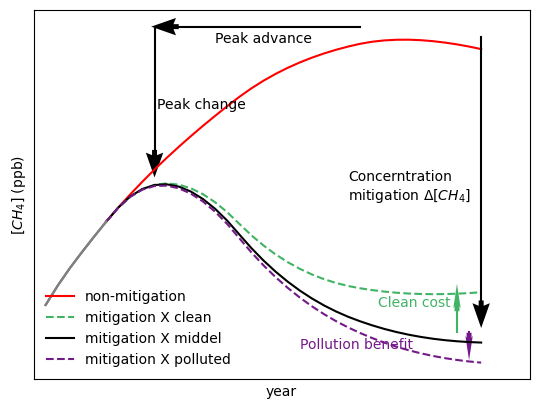

In [58]:
fig, ax = plt.subplots()



ax.plot(Out_scen_gmp.year.sel(year=slice(2019,2050)),Out_scen_real.isel(scen=0).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,label='non-mitigation',
         linestyle='-',color='r')
label_list = ['mitigation X middel','mitigation X clean','mitigation X polluted']
for i in [1,0,2]:
    if i == 0:
        linestyle = '-'
    else:
        linestyle = '--'
    ax.plot(Out_scen_gmp.year.sel(year=slice(2019,2050)),Out_scen_gmp.isel(scen=i).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,label=label_list[i],
             linestyle=linestyle,color=color_list[i])
ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),Out_scen_gmp.D_CH4.sel(year=slice(2014,2019)).mean('config')+Par0.CH4_0,color='grey')


def plot_quiver(ax,point1,point2,color='k',linestyle='-',headwidth=3.5):
    x0,y0 = point1
    x1,y1 = point2
    ax.plot([x0,x1],[y0,y1],color=color,linestyle=linestyle)
    ax.quiver(x1,y1,(x1-x0),(y1-y0),color=color, width=.01,headwidth=headwidth,)

### 环保与收益
plot_quiver(ax,(2050,2147),(2050,1828))
ax.text(2039,1950,'Concerntration\nmitigation Δ[$CH_4$]')


plot_quiver(ax,(2048,1790),(2048,1815),color=color_list[1],headwidth=1.5)
ax.text(2041.5,1820,'Clean cost',color=color_list[1])
plot_quiver(ax,(2049,1790),(2049,1789),color=color_list[2],headwidth=1.5)
ax.text(2035,1770,'Pollution benefit',color=color_list[2])


plot_quiver(ax,(2040,2159),(2025,2159),linestyle='-')
ax.text(2028,2140,'Peak advance')
plot_quiver(ax,(2023,2159),(2023,2010),linestyle='-')
ax.text(2023.2,2060,'Peak change')


# ## 下降速率
# ax.plot([2025,2040],[1930,1810],color='k')
# ax.quiver(2040,1810,1,-0.5,color='k', width=.01,headwidth=3.5,)
# ax.text(2033,1870,'Decrease rate')

ax.set_xticks([])
ax.set_yticks([])

ax.set_ylabel('$[CH_4]$ (ppb)')
ax.set_xlabel('year')
ax.legend(loc='lower left',frameon=False)
ax.set_xlim(2013,2054)
fig.savefig('示意图.pdf',dpi=300)

分解到NOX、CO、VOC

In [35]:
For_scen_gmp_clean = For_scen_gmp.sel(scen=['middle','clean','middle','middle','middle']).copy(deep=True).assign_coords(scen=np.array(['middle','clean','clean-NOX','clean-CO','clean-VOC']))

In [36]:
For_scen_gmp_clean['E_NOX'][:,:,2] = For_scen_gmp_clean['E_NOX'][:,:,1] #NOX
For_scen_gmp_clean['E_CO'][:,:,3] = For_scen_gmp_clean['E_CO'][:,:,1] #CO
For_scen_gmp_clean['E_VOC'][:,:,4] = For_scen_gmp_clean['E_VOC'][:,:,1] #VOC

In [37]:
Out_scen_gmp_clean = OSCAR(Ini=Ini, Par=Par_tmp, For=For_scen_gmp_clean, var_keep=var_keep+['f_kOH','f_kOH_O3P']+['RF'], nt=4)

OSCAR_v3 running
year = 2050 (nt = 4)
total running time: 1.6 minutes


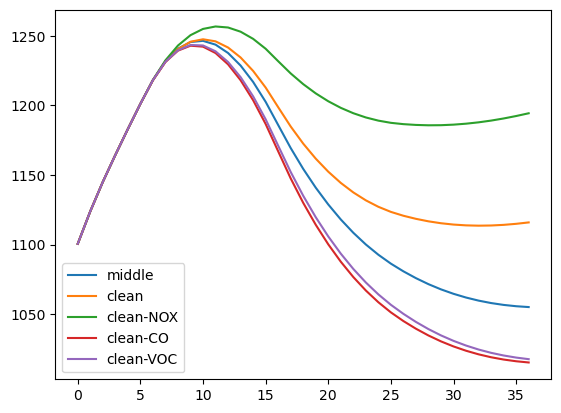

In [38]:
plt.plot(Out_scen_gmp_clean.D_CH4.mean('config'),label=Out_scen_gmp_clean.scen.values)
plt.legend()

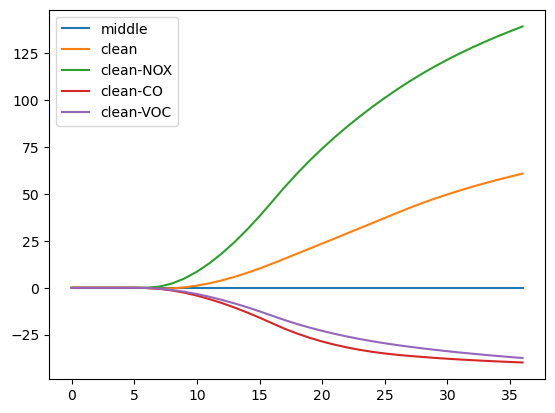

In [39]:
plt.plot(Out_scen_gmp_clean.D_CH4.mean('config')-Out_scen_gmp_clean.D_CH4.mean('config').isel(scen=0),label=Out_scen_gmp_clean.scen.values)
plt.legend()

(2015.0, 2050.0)

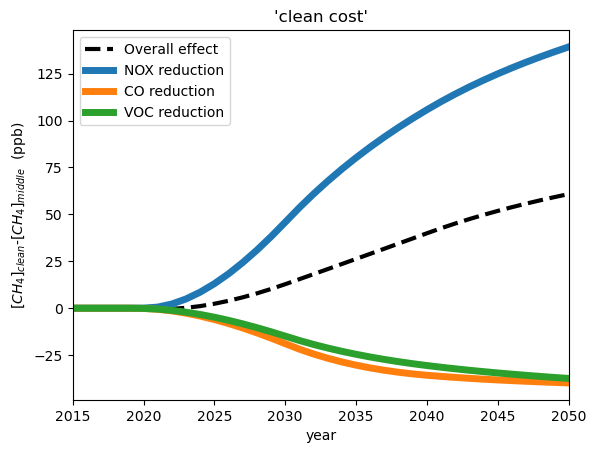

In [40]:
f, ax = plt.subplots()

temp = Out_scen_gmp_clean.D_CH4.mean('config')-Out_scen_gmp_clean.D_CH4.mean('config').isel(scen=0)

ax.plot(temp.year,temp.sel(scen='clean'),color='k',label='Overall effect',linestyle='--',linewidth=3)
# ax.plot(temp.year,temp.sel(scen=['clean-NOX','clean-CO','clean-VOC']).sum('scen'),color='grey',linestyle='--')

ax.plot(temp.year,temp.sel(scen='clean-NOX'),label='NOX reduction',linewidth=5)
ax.plot(temp.year,temp.sel(scen='clean-CO'),label='CO reduction',linewidth=5)
ax.plot(temp.year,temp.sel(scen='clean-VOC'),label='VOC reduction',linewidth=5)


ax.legend()

ax.set_xlabel('year')
ax.set_ylabel('$[CH_4]_{clean}$-$[CH_4]_{middle}$  (ppb)')
ax.set_title("'clean cost'")
ax.set_xlim(2015,2050)

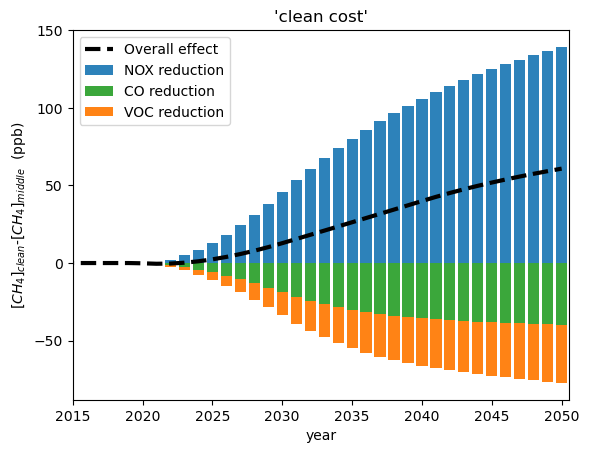

In [41]:
f, ax = plt.subplots()

temp = Out_scen_gmp_clean.D_CH4.mean('config')-Out_scen_gmp_clean.D_CH4.mean('config').isel(scen=0)

ax.plot(temp.year,temp.sel(scen='clean'),color='k',label='Overall effect',linestyle='--',linewidth=3)
# ax.plot(temp.year,temp.sel(scen=['clean-NOX','clean-CO','clean-VOC']).sum('scen'),color='grey',linestyle='--')

ax.bar(temp.year,temp.sel(scen='clean-NOX'),label='NOX reduction',linewidth=5,color='#2D82BA')

ax.bar(temp.year,temp.sel(scen='clean-VOC')+temp.sel(scen='clean-CO'),linewidth=5,color='#FF8315')
ax.bar(temp.year,temp.sel(scen='clean-CO'),label='CO reduction',linewidth=5,color='#3BA73B')
ax.bar(0,0,label='VOC reduction',linewidth=5,color='#FF8315')

ax.legend()

ax.set_xlabel('year')
ax.set_ylabel('$[CH_4]_{clean}$-$[CH_4]_{middle}$  (ppb)')
ax.set_title("'clean cost'")
ax.set_xlim(2015,2050.5)
f.savefig('Fig4a.pdf',dpi=300)

(2015.0, 2050.5)

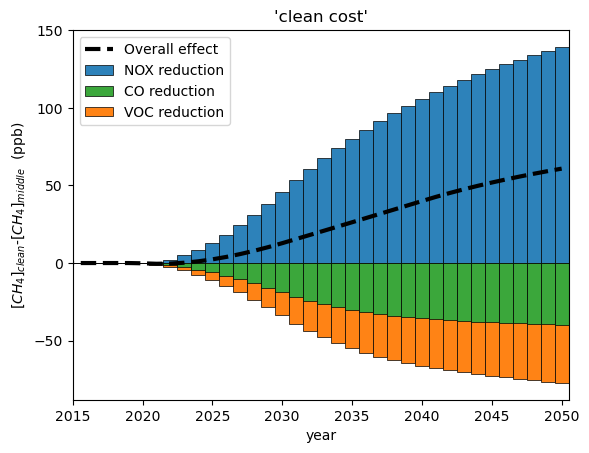

In [42]:
f, ax = plt.subplots()

temp = Out_scen_gmp_clean.D_CH4.mean('config')-Out_scen_gmp_clean.D_CH4.mean('config').isel(scen=0)

ax.plot(temp.year,temp.sel(scen='clean'),color='k',label='Overall effect',linestyle='--',linewidth=3)
# ax.plot(temp.year,temp.sel(scen=['clean-NOX','clean-CO','clean-VOC']).sum('scen'),color='grey',linestyle='--')

ax.bar(temp.year,temp.sel(scen='clean-NOX'),label='NOX reduction',color='#2D82BA',width=1,edgecolor='k',linewidth=0.5)

ax.bar(temp.year,temp.sel(scen='clean-VOC')+temp.sel(scen='clean-CO'),color='#FF8315',width=1,edgecolor='k',linewidth=0.5)
ax.bar(temp.year,temp.sel(scen='clean-CO'),label='CO reduction',color='#3BA73B',width=1,edgecolor='k',linewidth=0.5)
ax.bar(0,0,label='VOC reduction',color='#FF8315',width=1,edgecolor='k',linewidth=0.5)

ax.legend()

ax.set_xlabel('year')
ax.set_ylabel('$[CH_4]_{clean}$-$[CH_4]_{middle}$  (ppb)')
ax.set_title("'clean cost'")
ax.set_xlim(2015,2050.5)

In [43]:
(temp.sel(scen='clean')[36]-temp.sel(scen='clean')[6])/30

<xarray.DataArray 'D_CH4' ()>
array(2.03320759)
Coordinates:
    scen     <U9 'clean'

In [44]:
temp.sel(scen='clean-VOC')

<xarray.DataArray 'D_CH4' (year: 37)>
array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  -0.09975238,  -0.47956783,
        -1.15967812,  -2.11937854,  -3.33758017,  -4.79288513,
        -6.46372262,  -8.32870301, -10.36687817, -12.55796895,
       -14.8823771 , -17.20015099, -19.31048482, -21.22971002,
       -22.97403589, -24.55888952, -25.99852717, -27.30616307,
       -28.49389034, -29.572918  , -30.55355202, -31.45319497,
       -32.29175809, -33.07513463, -33.80894508, -34.4983826 ,
       -35.14824989, -35.76279743, -36.34589317, -36.90088377,
       -37.43061712])
Coordinates:
    scen     <U9 'clean-VOC'
  * year     (year) int64 2014 2015 2016 2017 2018 ... 2046 2047 2048 2049 2050

In [45]:
For_scen_gmp_polluted = For_scen_gmp.sel(scen=['middle','polluted','middle','middle','middle']).copy(deep=True).assign_coords(scen=np.array(['middle','polluted','polluted-NOX','polluted-CO','polluted-VOC']))

In [46]:
For_scen_gmp_polluted['E_NOX'][:,:,2] = For_scen_gmp_polluted['E_NOX'][:,:,1] #NOX
For_scen_gmp_polluted['E_CO'][:,:,3] = For_scen_gmp_polluted['E_CO'][:,:,1] #CO
For_scen_gmp_polluted['E_VOC'][:,:,4] = For_scen_gmp_polluted['E_VOC'][:,:,1] #VOC

In [47]:
Out_scen_gmp_polluted = OSCAR(Ini=Ini, Par=Par_tmp, For=For_scen_gmp_polluted, var_keep=var_keep+['f_kOH','f_kOH_O3P']+['RF'], nt=4)

OSCAR_v3 running
year = 2050 (nt = 4)
total running time: 1.6 minutes


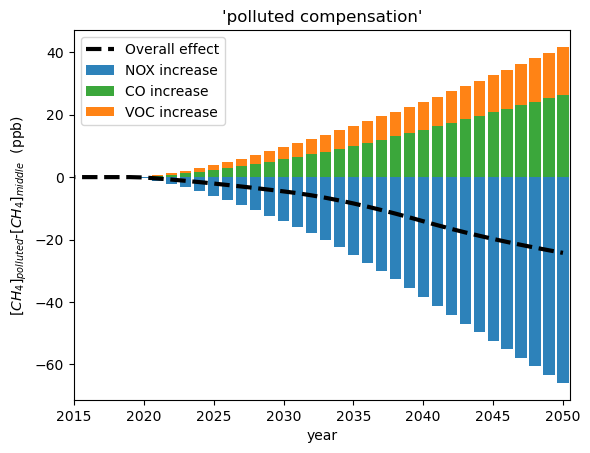

In [48]:
f, ax = plt.subplots()

temp = Out_scen_gmp_polluted.D_CH4.mean('config')-Out_scen_gmp_polluted.D_CH4.mean('config').isel(scen=0)

ax.plot(temp.year,temp.sel(scen='polluted'),color='k',label='Overall effect',linestyle='--',linewidth=3)
# ax.plot(temp.year,temp.sel(scen=['clean-NOX','clean-CO','clean-VOC']).sum('scen'),color='grey',linestyle='--')

ax.bar(temp.year,temp.sel(scen='polluted-NOX'),label='NOX increase',linewidth=5,color='#2D82BA')

ax.bar(temp.year,temp.sel(scen='polluted-VOC')+temp.sel(scen='polluted-CO'),linewidth=5,color='#FF8315')
ax.bar(temp.year,temp.sel(scen='polluted-CO'),label='CO increase',linewidth=5,color='#3BA73B')
ax.bar(0,0,label='VOC increase',linewidth=5,color='#FF8315')

ax.legend()

ax.set_xlabel('year')
ax.set_ylabel('$[CH_4]_{polluted}$-$[CH_4]_{middle}$  (ppb)')
ax.set_title("'polluted compensation'")
ax.set_xlim(2015,2050.5)
f.savefig('Fig4b.pdf',dpi=300)

In [49]:
(temp.sel(scen='polluted')[36]-temp.sel(scen='polluted')[6])/30

<xarray.DataArray 'D_CH4' ()>
array(-0.80553968)
Coordinates:
    scen     <U12 'polluted'

In [50]:
temp.sel(scen='polluted-VOC')

<xarray.DataArray 'D_CH4' (year: 37)>
array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.06406962,  0.25314819,  0.4942134 ,  0.78323319,
        1.11620186,  1.48910668,  1.89793979,  2.33876535,  2.80776305,
        3.30126553,  3.8157494 ,  4.34104676,  4.86412183,  5.38483207,
        5.90326893,  6.41962994,  6.93410755,  7.44691518,  7.95824018,
        8.46830963,  8.97736613,  9.49750265, 10.04687844, 10.62327939,
       11.22476488, 11.8495986 , 12.49625333, 13.1632746 , 13.84935413,
       14.55320476, 15.27353114])
Coordinates:
    scen     <U12 'polluted-VOC'
  * year     (year) int64 2014 2015 2016 2017 2018 ... 2046 2047 2048 2049 2050

____

____

____

____

In [ ]:
mittigation = Out_scen_real.D_CH4.mean('config').sel(year=slice(2019,2050))-Out_scen_gmp.D_CH4.mean('config').sel(year=slice(2019,2050))

In [ ]:
For_scen_gmp_change = For_scen_gmp.copy(deep=True)

### 2030相对于2020减排30%，假设之后保持固定

E_CH4_2020_2030 = np.linspace(For_scen_gmp['E_CH4'].sel(year=2020),For_scen_gmp['E_CH4'].sel(year=2020)*0.7,11)
For_scen_gmp['E_CH4'][:,2020-2014:2030-2014+1,:] = np.transpose(E_CH4_2020_2030,[1,0,2])
For_scen_gmp['E_CH4'][:,2030-2014+1:,:] = np.transpose(np.array([E_CH4_2020_2030[-1]]*20),[1,0,2])

In [ ]:
For_scen_gmp_change = For_scen_gmp.sel(scen=['middle','middle','middle','middle','middle','middle','middle']).copy(deep=True).assign_coords(scen=np.array(['-10','-5','-1','0','+1','+5','+10']))


ratio = [-10,-5,-1,0,1,5,10]

for i in range(len(ratio)):
    E_CH4_2020_2030 = np.linspace(For_scen_gmp_change['E_CH4'].isel(scen=i).sel(year=2020),For_scen_gmp_change['E_CH4'].isel(scen=i).sel(year=2020)*(0.7+ratio[i]/100),11)
    For_scen_gmp_change['E_CH4'][:,2020-2014:2030-2014+1,i] = np.transpose(E_CH4_2020_2030,[1,0])
    For_scen_gmp_change['E_CH4'][:,2030-2014+1:,i] = np.transpose(np.array([E_CH4_2020_2030[-1]]*20),[1,0])

In [ ]:
Out_scen_gmp_change = OSCAR(Ini=Ini, Par=Par_tmp, For=For_scen_gmp_change, var_keep=var_keep+['f_kOH','f_kOH_O3P']+['RF'], nt=4)

In [ ]:
fig, ax = plt.subplots()

ax.plot(Out_scen_gmp.year.sel(year=slice(2019,2050)),Out_scen_real.isel(scen=0).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,label='no-GMP',
         linestyle='-',color='r')

for i in range(len(Out_scen_real.scen)):
    ax.plot(Out_scen_gmp.year.sel(year=slice(2019,2050)),Out_scen_gmp.isel(scen=i).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,label=label_list[i],
             linestyle='--',color=color_list[i])
ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),Out_scen_gmp.D_CH4.sel(year=slice(2014,2019)).mean('config')+Par0.CH4_0,color='grey')


text_list = ['+10%','+5%','+1%','','-1%','-5%','-10%']
for i in range(len(Out_scen_gmp_change.scen)):
    ax.plot(Out_scen_gmp.year.sel(year=slice(2019,2050)),Out_scen_gmp_change.isel(scen=i).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,
             linestyle=':',color='k',alpha=0.5)
    ax.text(2050,(Out_scen_gmp_change.isel(scen=i).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0)[-1]-5,text_list[i])
ax.plot(Out_scen_gmp.year.sel(year=slice(2019,2050))[0],(Out_scen_gmp_change.isel(scen=i).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0)[0],
         linestyle=':',color='k',alpha=0.5,label='enhanced/weakened GMP')

ax.text(2045,1800,'-6.5%',color=color_list[1])
ax.text(2045,1660,'+2.5%',color=color_list[2])

ax.set_ylabel('$[CH_4]$ (ppb)')
ax.set_xlabel('year')
ax.legend(frameon=False)



# ax.set_ylim(1500,2100)
ax.set_xlim(2013,2054)
# fig.savefig('GMP.pdf',dpi=300)

In [ ]:
For_scen_gmp_change_clean = For_scen_gmp.sel(scen=['middle','middle','middle','middle','middle']).copy(deep=True).assign_coords(scen=np.array(['1','2','3','4','5']))


ratio = [5,6,7,8,9]

for i in range(len(ratio)):
    E_CH4_2020_2030 = np.linspace(For_scen_gmp_change_clean['E_CH4'].isel(scen=i).sel(year=2020),For_scen_gmp_change_clean['E_CH4'].isel(scen=i).sel(year=2020)*(0.7+ratio[i]/100),11)
    For_scen_gmp_change_clean['E_CH4'][:,2020-2014:2030-2014+1,i] = np.transpose(E_CH4_2020_2030,[1,0])
    For_scen_gmp_change_clean['E_CH4'][:,2030-2014+1:,i] = np.transpose(np.array([E_CH4_2020_2030[-1]]*20),[1,0])

In [ ]:
Out_scen_gmp_change_clean = OSCAR(Ini=Ini, Par=Par_tmp, For=For_scen_gmp_change_clean, var_keep=var_keep+['f_kOH','f_kOH_O3P']+['RF'], nt=4)

In [ ]:
For_scen_gmp_change_polluted = For_scen_gmp.sel(scen=['middle','middle','middle','middle','middle']).copy(deep=True).assign_coords(scen=np.array(['1','2','3','4','5']))


ratio = [-1,-2,-3,-4,-5]

for i in range(len(ratio)):
    E_CH4_2020_2030 = np.linspace(For_scen_gmp_change_polluted['E_CH4'].isel(scen=i).sel(year=2020),For_scen_gmp_change_polluted['E_CH4'].isel(scen=i).sel(year=2020)*(0.7+ratio[i]/100),11)
    For_scen_gmp_change_polluted['E_CH4'][:,2020-2014:2030-2014+1,i] = np.transpose(E_CH4_2020_2030,[1,0])
    For_scen_gmp_change_polluted['E_CH4'][:,2030-2014+1:,i] = np.transpose(np.array([E_CH4_2020_2030[-1]]*20),[1,0])

In [ ]:
Out_scen_gmp_change_polluted = OSCAR(Ini=Ini, Par=Par_tmp, For=For_scen_gmp_change_polluted, var_keep=var_keep+['f_kOH','f_kOH_O3P']+['RF'], nt=4)

In [ ]:
Out_scen_gmp_change_polluted.D_CH4.mean('config').sel(year=2050)

# 3*3实验
不同减排*不同空气质量

In [ ]:
scen_list = []

scen_1_list = ['p','m','c']
scen_2_list = [4,3,2,1,0]

for x in scen_1_list:
    for y in scen_2_list:
        scen_list.append(x+str(y))

For_scen_gmp_change = For_scen_gmp.sel(scen=['polluted']*5+['middle']*5+['clean']*5).copy(deep=True).assign_coords(scen=np.array(scen_list))

# GMP强度
ratio = [-10,-5,0,5,10]

for y in scen_2_list:
    j = scen_2_list.index(y)
#     print(scen)
    for x in scen_1_list:
        scen = x+str(y)
        E_CH4_2020_2030 = np.linspace(For_scen_gmp_change['E_CH4'].sel(scen=scen).sel(year=2020),For_scen_gmp_change['E_CH4'].sel(scen=scen).sel(year=2020)*(0.7+ratio[j]/100),11)
        index = For_scen_gmp_change.scen.values.tolist().index(scen)
        For_scen_gmp_change['E_CH4'][:,2020-2014:2030-2014+1,index] = np.transpose(E_CH4_2020_2030,[1,0])
        For_scen_gmp_change['E_CH4'][:,2030-2014+1:,index] = np.transpose(np.array([E_CH4_2020_2030[-1]]*20),[1,0])
        
        

In [ ]:
Out_scen_gmp_change_polluted = OSCAR(Ini=Ini, Par=Par_tmp, For=For_scen_gmp_change, var_keep=var_keep+['f_kOH','f_kOH_O3P']+['RF'], nt=4)

In [ ]:
plt.plot(Out_scen_gmp_change_polluted.year,For_scen_gmp_change.E_CH4.sum('reg_land'))

In [ ]:
scen = ['m0','p0','c0']
plt.plot(Out_scen_gmp_change_polluted.year,For_scen_gmp_change.E_NOX.sum('reg_land').sel(scen=scen),label=For_scen_gmp_change.scen.sel(scen=scen).values)
plt.legend()

In [ ]:
fig, ax = plt.subplots()

ax.plot(Out_scen_gmp.year.sel(year=slice(2019,2050)),Out_scen_real.isel(scen=0).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,#label='no-GMP',
         linestyle='-',color='r')

scen_1_list = ['p','m','c']
scen_2_list = [4,2,0]

linestyle_list = [':','-','--']
linewidth_list = [1,3,1]
color_list = ['#741A88','k','#41B365',]


label_1_list = ['polluted','middle','clean']
label_2_list = ['20%','30%','40%']
for x in scen_1_list:
    for y in scen_2_list:
        scen = x+str(y)
#         print(scen)
        i = scen_1_list.index(x)
        j = scen_2_list.index(y)
        ax.plot(Out_scen_gmp.year.sel(year=slice(2019,2050)),Out_scen_gmp_change_polluted.sel(scen=scen).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,
                label=label_1_list[i]+'-'+label_2_list[j],
                linestyle=linestyle_list[j],color=color_list[i],linewidth=linewidth_list[j])

#         ax.plot(Out_scen_gmp.year.sel(year=slice(2019,2050)),Out_scen_gmp_change_polluted.sel(scen=scen).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,
#                 label=scen,
#                 linestyle=linestyle_list[j],color=color_list[i],linewidth=linewidth_list[j])        

#         print((Out_scen_gmp_change_polluted.sel(scen=scen).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0).values[-1])
ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),Out_scen_gmp.D_CH4.sel(year=slice(2014,2019)).mean('config')+Par0.CH4_0,color='grey')
ax.legend(ncol=3)

In [ ]:
fig, ax = plt.subplots()

ax.plot(Out_scen_gmp.year.sel(year=slice(2019,2050)),Out_scen_real.isel(scen=0).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,#label='no-GMP',
         linestyle='-',color='r')

scen_1_list = ['p','m','c']
scen_2_list = [4,2,0]

linestyle_list = [':','-','--']
linewidth_list = [1,3,1]
color_list = ['#741A88','k','#41B365',]
marker_list = ['<','','x']

label_1_list = ['polluted','middle','clean']
label_2_list = ['20%','30%','40%']
for x in scen_1_list:
    for y in scen_2_list:
        scen = x+str(y)
        
        i = scen_1_list.index(x)
        j = scen_2_list.index(y)
        ax.plot(Out_scen_gmp.year.sel(year=slice(2019,2050)),Out_scen_gmp_change_polluted.sel(scen=scen).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,
                label=label_1_list[i]+'-'+label_2_list[j],
                linestyle=linestyle_list[j],color=color_list[i],linewidth=linewidth_list[j],
               marker=marker_list[j],markersize=4
               )

ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),Out_scen_gmp.D_CH4.sel(year=slice(2014,2019)).mean('config')+Par0.CH4_0,color='grey')
ax.legend(ncol=3)


ax.set_ylabel('$[CH_4]$ (ppb)')
ax.set_xlabel('year')

ax.set_ylim(1500,2100)
ax.set_xlim(2013,2054)

fig.savefig('3x3实验.pdf',dpi=300)

In [ ]:
Out_scen_gmp_change_polluted.scen

In [ ]:
Out_scen_gmp_change_polluted.D_CH4.isel(year=-1).mean('config').sel(scen=['c2','m4', 'm3', 'm2', 'm1', 'm0'])

In [ ]:
fig, ax = plt.subplots()

ax.plot(Out_scen_gmp.year.sel(year=slice(2019,2050)),Out_scen_real.isel(scen=0).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,#label='no-GMP',
         linestyle='-',color='r')

scen_1_list = ['p','m','c']
scen_2_list = [4,2,0]

linestyle_list = [':','-','--']
linewidth_list = [1,3,1]
color_list = ['#741A88','k','#41B365',]
marker_list = ['<','','x']

label_1_list = ['polluted','middle','clean']
label_2_list = ['20%','30%','40%']

for y in scen_2_list:
    for x in scen_1_list:
        scen = x+str(y)
        
        i = scen_1_list.index(x)
        j = scen_2_list.index(y)
        ax.plot(Out_scen_gmp.year.sel(year=slice(2019,2050)),Out_scen_gmp_change_polluted.sel(scen=scen).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,
                label=label_1_list[i]+'-'+label_2_list[j],
                linestyle=linestyle_list[j],color=color_list[i],linewidth=linewidth_list[j],
               marker=marker_list[j],markersize=4
               )

ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),Out_scen_gmp.D_CH4.sel(year=slice(2014,2019)).mean('config')+Par0.CH4_0,color='grey')
ax.legend(ncol=3)


ax.set_ylabel('$[CH_4]$ (ppb)')
ax.set_xlabel('year')

ax.set_ylim(1500,2100)
ax.set_xlim(2013,2054)

fig.savefig('3x3实验.pdf',dpi=300)

In [ ]:
fig, ax = plt.subplots()

ax.plot(Out_scen_gmp.year.sel(year=slice(2019,2050)),Out_scen_real.isel(scen=0).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,#label='no-GMP',
         linestyle='-',color='r')

scen_1_list = ['p','m','c']
scen_2_list = [4,2,0]

linestyle_list = [':','-','--']
linewidth_list = [1,3,1]
color_list = ['#741A88','k','#41B365',]
marker_list = ['<','','x']

label_1_list = ['polluted','middel','clean']
label_2_list = ['20%','30%','40%']

for y in scen_2_list:
    for x in scen_1_list:
        scen = x+str(y)
        
        i = scen_1_list.index(x)
        j = scen_2_list.index(y)
        ax.plot(Out_scen_gmp.year.sel(year=slice(2019,2050)),Out_scen_gmp_change_polluted.sel(scen=scen).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,
                label=label_1_list[i]+'-'+label_2_list[j],
                linestyle=linestyle_list[j],color=color_list[i],linewidth=linewidth_list[j],
               marker=marker_list[j],markersize=4
               )
        if y == 2:
            print(scen)
            print((Out_scen_gmp_change_polluted.sel(scen=scen).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0).max().values)
#             print((Out_scen_gmp_change_polluted.sel(scen=scen).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0).values)
#             print((Out_scen_gmp_change_polluted.sel(scen=scen).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0)[-1].values)
ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),Out_scen_gmp.D_CH4.sel(year=slice(2014,2019)).mean('config')+Par0.CH4_0,color='grey')
# ax.legend(ncol=3)


ax.set_ylabel('$[CH_4]$ (ppb)')
ax.set_xlabel('year')

ax.set_ylim(1600,2200)
ax.set_xlim(2013,2054)

# fig.savefig('GMP.pdf',dpi=300)

In [ ]:
fig, ax = plt.subplots()

ax.plot(Out_scen_gmp.year.sel(year=slice(2019,2050)),Out_scen_real.isel(scen=0).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,#label='no-GMP',
         linestyle='-',color='r')

scen_1_list = ['p','m','c']
scen_2_list = [4,3,2,1,0]

linestyle_list = [':',':','-','--','--']
linewidth_list = [1,1,3,1,1]
color_list = ['#741A88','k','#41B365',]
marker_list = ['<','<','','x','x']

label_1_list = ['polluted','middel','clean']
label_2_list = ['20%','25','30%','35%','40%']

for y in scen_2_list:
    for x in scen_1_list:
        scen = x+str(y)
        
        i = scen_1_list.index(x)
        j = scen_2_list.index(y)
        ax.plot(Out_scen_gmp.year.sel(year=slice(2019,2050)),Out_scen_gmp_change_polluted.sel(scen=scen).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,
                label=label_1_list[i]+'-'+label_2_list[j],
                linestyle=linestyle_list[j],color=color_list[i],linewidth=linewidth_list[j],
               marker=marker_list[j],markersize=4
               )
        if y == 2:
            print(scen)
            print((Out_scen_gmp_change_polluted.sel(scen=scen).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0).max().values)
#             print((Out_scen_gmp_change_polluted.sel(scen=scen).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0).values)
#             print((Out_scen_gmp_change_polluted.sel(scen=scen).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0)[-1].values)
ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),Out_scen_gmp.D_CH4.sel(year=slice(2014,2019)).mean('config')+Par0.CH4_0,color='grey')
# ax.legend(ncol=3)


ax.set_ylabel('$[CH_4]$ (ppb)')
ax.set_xlabel('year')

ax.set_ylim(1600,2200)
ax.set_xlim(2013,2054)

# fig.savefig('GMP-extended.pdf',dpi=300)

In [ ]:
Out_scen_gmp_change_polluted.scen

In [ ]:
fig, ax = plt.subplots()

ax.plot(Out_scen_gmp.year.sel(year=slice(2019,2050)),Out_scen_real.isel(scen=0).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,#label='no-GMP',
         linestyle='-',color='r')

scen_1_list = ['p','m','c']
scen_2_list = [4,3,2,1,0]

linestyle_list = [':',':','-','--','--']
linewidth_list = [1,1,3,1,1]
color_list = ['#741A88','k','#41B365',]
marker_list = ['<','<','','x','x']

label_1_list = ['polluted','middel','clean']
label_2_list = ['40%','35%','30%','25%','20%']

scen_list = ['m2','c3']

for y in scen_2_list:
    for x in scen_1_list:
        scen = x+str(y)
        
        if scen  not in scen_list:
            continue
        
        i = scen_1_list.index(x)
        j = scen_2_list.index(y)
        ax.plot(Out_scen_gmp.year.sel(year=slice(2019,2050)),Out_scen_gmp_change_polluted.sel(scen=scen).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,
                label=label_1_list[i]+'-'+label_2_list[j],
                linestyle=linestyle_list[j],color=color_list[i],linewidth=linewidth_list[j],
               marker=marker_list[j],markersize=4
               )
        if y == 2:
            print(scen)
            print((Out_scen_gmp_change_polluted.sel(scen=scen).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0).max().values)
#             print((Out_scen_gmp_change_polluted.sel(scen=scen).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0).values)
#             print((Out_scen_gmp_change_polluted.sel(scen=scen).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0)[-1].values)
ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),Out_scen_gmp.D_CH4.sel(year=slice(2014,2019)).mean('config')+Par0.CH4_0,color='grey')
ax.legend(ncol=3)


ax.set_ylabel('$[CH_4]$ (ppb)')
ax.set_xlabel('year')

ax.set_ylim(1600,2200)
ax.set_xlim(2013,2054)

fig.savefig('GMP-extended.pdf',dpi=300)

# 理想实验(排放稳定)

In [ ]:
For_scen_ideal = For_scen_real.sel(year=slice(2014,2050)).copy(deep=True)

In [ ]:
for year in np.arange(2014,2050+1):
#     print(year)
    pass
    if year >= 2020:
        For_scen_ideal.E_CH4[:,year-2014,:] = For_scen_ideal.E_CH4[:,2019-2014,:]

In [ ]:
Out_scen_ideal = OSCAR(Ini=Ini, Par=Par_tmp, For=For_scen_ideal, var_keep=var_keep+['f_kOH','f_kOH_O3P', 'D_Ebb','f_hv','D_Ewet','D_Epf_CH4','D_O3s','D_Ta', 'D_f_Qa'], nt=4)

In [ ]:
def f_lifetime(E_NO,E_CO,E_VOC=0):
    return -0.414*E_NO+0.024*E_CO+0.027*E_VOC

In [ ]:
def f_lifetime(E_NO,E_CO,E_VOC=0):
    return -0.414*E_NO+0.024*E_CO+0.027*E_VOC

In [ ]:
plt.plot(Out_scen_ideal.year,Out_scen_ideal.tau_CH4.mean('config'))

In [ ]:
plt.plot(Out_scen_ideal.year,Out_scen_ideal.D_CH4.mean('config'))

In [ ]:
plt.plot(f_lifetime(For_scen_ideal.E_NOX.sum('reg_land'),For_scen_ideal.E_CO.sum('reg_land'),For_scen_ideal.E_VOC.sum('reg_land')))

In [ ]:
fig, ax = plt.subplots()

scen_1_list = ['p','m','c']
scen_2_list = [4,2,0]

linestyle_list = [':','-','--']
linewidth_list = [1,3,1]
color_list = ['#741A88','k','#41B365',]
marker_list = ['<','','x']

label_list = ['polluted','middle','clean']



for i in range(3):
    ax.plot(Out_scen_ideal.year,Out_scen_ideal.tau_CH4.mean('config').sel(scen=label_list[i]),label=label_list[i],
#             color=color_list[i],
            color='r',linestyle=linestyle_list[i])
#     ax.plot(f_lifetime(For_scen_ideal.E_NOX.sum('reg_land'),For_scen_ideal.E_CO.sum('reg_land'),For_scen_ideal.E_VOC.sum('reg_land')))
    
ax.legend()

In [ ]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist

In [ ]:
x = Out_scen_ideal.year.values
y1 = f_lifetime(For_scen_ideal.E_NOX.sum('reg_land'),For_scen_ideal.E_CO.sum('reg_land'),For_scen_ideal.E_VOC.sum('reg_land')).values  #fo3p
y2 = Out_scen_ideal.tau_CH4.mean('config').values # tau
y3 = (Out_scen_ideal.D_CH4.mean('config')+Par0.CH4_0).values # CH4


In [ ]:
from mpl_toolkits.axisartist.parasite_axes import HostAxes, ParasiteAxes

In [ ]:
from mpl_toolkits.axisartist.parasite_axes import HostAxes, ParasiteAxes
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
# 设置中文显示
font = {'family':'Microsoft YaHei', 'weight':'bold', 'size':12}
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
matplotlib.rc('font', **font)

In [ ]:
linestyle_list

In [ ]:
linestyle_list = ['-',':','--']
marker_list = ['<','','x']

fig = plt.figure(figsize=(10, 6)) 
ax = HostAxes(fig, [0.1, 0.1, 0.9, 0.9])  #用[left, bottom, weight, height]的方式定义axes, 0 <= l,b,w,h <= 1
kw = dict(linewidth = 2,markerfacecolor='none',markersize = 4)

#parasite addtional axes, share x
ax02 = ParasiteAxes(ax, sharex=ax)
ax03 = ParasiteAxes(ax, sharex=ax)

#append axes
ax.parasites.append(ax02)
ax.parasites.append(ax03)

ax03_axisline = ax02.get_grid_helper().new_fixed_axis
ax03.axis['right4'] = ax03_axisline(loc='right', axes=ax03, offset=(80,0))

ax01 = ax

fig.add_axes(ax)

i = 0
for i in [0,1,2]:
    pass
    h1 = ax01.plot(  x,y3[:,i],linewidth=2,color=color_list[1],linestyle=linestyle_list[i])
    h2 = ax02.plot(x,y1[:,i],linewidth=2,color=color_list[0],linestyle=linestyle_list[i])
    h3 = ax03.plot(x,y2[:,i],linewidth=2,color=color_list[2],linestyle=linestyle_list[i])

#invisible right axis of ax
ax01.axis['right'].set_visible(False)
ax01.axis['top'].set_visible(True)
ax02.axis['right'].set_visible(True)
ax02.axis['right'].major_ticklabels.set_visible(True)
ax02.axis['right'].label.set_visible(True)

#set label for axis
ax01.set_xlabel('year')
ax01.set_ylabel('$CH_4$ (ppb)')
ax02.set_ylabel('$f_{O_3P}$ (%)')
ax03.set_ylabel('Lifetime (d)')

# ax.legend()

#name axies, xticks colors
ax01.axis['left'].label.set_color(color_list[1])
ax02.axis['right'].label.set_color(color_list[0])
ax03.axis['right4'].label.set_color(color_list[2])

ax01.axis['left'].major_ticks.set_color(color_list[1])
ax02.axis['right'].major_ticks.set_color(color_list[0])
ax03.axis['right4'].major_ticks.set_color(color_list[2])

ax01.axis['left'].major_ticklabels.set_color(color_list[1])
ax02.axis['right'].major_ticklabels.set_color(color_list[0])
ax03.axis['right4'].major_ticklabels.set_color(color_list[2])

ax01.axis['left'].line.set_color(color_list[1])
ax02.axis['right'].line.set_color(color_list[0])
ax03.axis['right4'].line.set_color(color_list[2])

In [ ]:
linestyle_list = ['-',':','--']
marker_list = ['<','o','*']

markersize = 6
linewidth = 1

fig = plt.figure(figsize=(10, 6)) 
ax = HostAxes(fig, [0.1, 0.1, 0.9, 0.9])  #用[left, bottom, weight, height]的方式定义axes, 0 <= l,b,w,h <= 1
kw = dict(linewidth = 2,markerfacecolor='none',markersize = 4)

#parasite addtional axes, share x
ax02 = ParasiteAxes(ax, sharex=ax)
ax03 = ParasiteAxes(ax, sharex=ax)

#append axes
ax.parasites.append(ax02)
ax.parasites.append(ax03)

ax03_axisline = ax02.get_grid_helper().new_fixed_axis
ax03.axis['right4'] = ax03_axisline(loc='right', axes=ax03, offset=(80,0))

ax01 = ax



fig.add_axes(ax)
for i in [0,1,2]:
    if i%3 ==0:
        h1 = ax01.plot(  x,y3[:,i],linewidth=linewidth,color=color_list[1],linestyle='-'
                      ,marker=marker_list[i],markersize=markersize,
                      label='polluted')
        h2 = ax02.plot(x,y1[:,i],linewidth=linewidth,color=color_list[0],linestyle='-'#,linestyle=linestyle_list[i],
                      ,marker=marker_list[i],markersize=markersize,
                      label='middel')
        h3 = ax03.plot(x,y2[:,i],linewidth=linewidth,color=color_list[2],linestyle='-'#,linestyle=linestyle_list[i],
                      ,marker=marker_list[i],markersize=markersize,
                      label='clean')
    else:
        h1 = ax01.plot(  x,y3[:,i],linewidth=linewidth,color=color_list[1],linestyle='-'
                      ,marker=marker_list[i],markersize=markersize,
                      label='$CH_4$')
        h2 = ax02.plot(x,y1[:,i],linewidth=linewidth,color=color_list[0],linestyle='-'#,linestyle=linestyle_list[i],
                      ,marker=marker_list[i],markersize=markersize,
                      label='$RCL$')
        h3 = ax03.plot(x,y2[:,i],linewidth=linewidth,color=color_list[2],linestyle='-'#,linestyle=linestyle_list[i],
                      ,marker=marker_list[i],markersize=markersize,
                      label='Lifetime')        

#invisible right axis of ax
ax01.axis['right'].set_visible(False)
ax01.axis['top'].set_visible(True)
ax02.axis['right'].set_visible(True)
ax02.axis['right'].major_ticklabels.set_visible(True)
ax02.axis['right'].label.set_visible(True)

#set label for axis
ax01.set_xlabel('year')
ax01.set_ylabel('$CH_4$ (ppb)')
ax02.set_ylabel('$RCL$ (%)')
ax03.set_ylabel('Lifetime (yr)')

#name axies, xticks colors
ax01.axis['left'].label.set_color(color_list[1])
ax02.axis['right'].label.set_color(color_list[0])
ax03.axis['right4'].label.set_color(color_list[2])

ax01.axis['left'].major_ticks.set_color(color_list[1])
ax02.axis['right'].major_ticks.set_color(color_list[0])
ax03.axis['right4'].major_ticks.set_color(color_list[2])

ax01.axis['left'].major_ticklabels.set_color(color_list[1])
ax02.axis['right'].major_ticklabels.set_color(color_list[0])
ax03.axis['right4'].major_ticklabels.set_color(color_list[2])

ax01.axis['left'].line.set_color(color_list[1])
ax02.axis['right'].line.set_color(color_list[0])
ax03.axis['right4'].line.set_color(color_list[2])

ax.legend(ncol=3,frameon=False)

fig.savefig('理想实验.pdf',dpi=600, bbox_inches='tight')

In [ ]:
linestyle_list = ['-',':','--']
marker_list = ['<','o','*']

color_list = ['#2071aa','#ee7b21','#309738']

markersize = 6
linewidth = 1

fig = plt.figure(figsize=(10, 6)) 
ax = HostAxes(fig, [0.1, 0.1, 0.9, 0.9])  #用[left, bottom, weight, height]的方式定义axes, 0 <= l,b,w,h <= 1
kw = dict(linewidth = 2,markerfacecolor='none',markersize = 4)

#parasite addtional axes, share x
ax02 = ParasiteAxes(ax, sharex=ax)
ax03 = ParasiteAxes(ax, sharex=ax)

#append axes
ax.parasites.append(ax02)
ax.parasites.append(ax03)

ax03_axisline = ax02.get_grid_helper().new_fixed_axis
ax03.axis['right4'] = ax03_axisline(loc='right', axes=ax03, offset=(80,0))

ax01 = ax



fig.add_axes(ax)
for i in [0,1,2]:
    if i%3 ==0:
        h1 = ax01.plot(  x,y3[:,i],linewidth=linewidth,color=color_list[1],linestyle='-'
                      ,marker=marker_list[i],markersize=markersize,
                      label='polluted')
        h2 = ax02.plot(x,y1[:,i],linewidth=linewidth,color=color_list[0],linestyle='-'#,linestyle=linestyle_list[i],
                      ,marker=marker_list[i],markersize=markersize,
                      label='middel')
        h3 = ax03.plot(x,y2[:,i],linewidth=linewidth,color=color_list[2],linestyle='-'#,linestyle=linestyle_list[i],
                      ,marker=marker_list[i],markersize=markersize,
                      label='clean')
    else:
        h1 = ax01.plot(  x,y3[:,i],linewidth=linewidth,color=color_list[1],linestyle='-'
                      ,marker=marker_list[i],markersize=markersize,
                      label='$CH_4$')
        h2 = ax02.plot(x,y1[:,i],linewidth=linewidth,color=color_list[0],linestyle='-'#,linestyle=linestyle_list[i],
                      ,marker=marker_list[i],markersize=markersize,
                      label='$RCL$')
        h3 = ax03.plot(x,y2[:,i],linewidth=linewidth,color=color_list[2],linestyle='-'#,linestyle=linestyle_list[i],
                      ,marker=marker_list[i],markersize=markersize,
                      label='Lifetime')        

#invisible right axis of ax
ax01.axis['right'].set_visible(False)
ax01.axis['top'].set_visible(True)
ax02.axis['right'].set_visible(True)
ax02.axis['right'].major_ticklabels.set_visible(True)
ax02.axis['right'].label.set_visible(True)

#set label for axis
ax01.set_xlabel('year')
ax01.set_ylabel('$CH_4$ (ppb)')
ax02.set_ylabel('$RCL$ (%)')
ax03.set_ylabel('Lifetime (yr)')

#name axies, xticks colors
ax01.axis['left'].label.set_color(color_list[1])
ax02.axis['right'].label.set_color(color_list[0])
ax03.axis['right4'].label.set_color(color_list[2])

ax01.axis['left'].major_ticks.set_color(color_list[1])
ax02.axis['right'].major_ticks.set_color(color_list[0])
ax03.axis['right4'].major_ticks.set_color(color_list[2])

ax01.axis['left'].major_ticklabels.set_color(color_list[1])
ax02.axis['right'].major_ticklabels.set_color(color_list[0])
ax03.axis['right4'].major_ticklabels.set_color(color_list[2])

ax01.axis['left'].line.set_color(color_list[1])
ax02.axis['right'].line.set_color(color_list[0])
ax03.axis['right4'].line.set_color(color_list[2])

ax.legend(ncol=3,frameon=False)

fig.savefig('理想实验.pdf',dpi=600, bbox_inches='tight')

In [ ]:
linestyle_list = ['-',':','--']
marker_list = ['<','o','*']

color_list = ['#2071aa','#ee7b21','#309738']

markersize = 6
linewidth = 1

fig = plt.figure(figsize=(10, 6)) 
ax = HostAxes(fig, [0.1, 0.1, 0.9, 0.9])  #用[left, bottom, weight, height]的方式定义axes, 0 <= l,b,w,h <= 1
kw = dict(linewidth = 2,markerfacecolor='none',markersize = 4)

#parasite addtional axes, share x
ax02 = ParasiteAxes(ax, sharex=ax)
ax03 = ParasiteAxes(ax, sharex=ax)

#append axes
ax.parasites.append(ax02)
ax.parasites.append(ax03)

ax03_axisline = ax02.get_grid_helper().new_fixed_axis
ax03.axis['right4'] = ax03_axisline(loc='right', axes=ax03, offset=(80,0))

ax01 = ax



fig.add_axes(ax)
for i in [0,1,2]:
    if i%3 ==0:
        h1 = ax01.plot(  x,y3[:,i],linewidth=linewidth,color=color_list[1],linestyle='-'
                      ,marker=marker_list[i],markersize=markersize,
                      label='polluted')
        h2 = ax02.plot(x,y1[:,i],linewidth=linewidth,color=color_list[0],linestyle='-'#,linestyle=linestyle_list[i],
                      ,marker=marker_list[i],markersize=markersize,
                      label='middel')
        h3 = ax03.plot(x,y2[:,i],linewidth=linewidth,color=color_list[2],linestyle='-'#,linestyle=linestyle_list[i],
                      ,marker=marker_list[i],markersize=markersize,
                      label='clean')
    else:
        h1 = ax01.plot(  x,y3[:,i],linewidth=linewidth,color=color_list[1],linestyle='-'
                      ,marker=marker_list[i],markersize=markersize,
                      label='$CH_4$')
        h2 = ax02.plot(x,y1[:,i],linewidth=linewidth,color=color_list[0],linestyle='-'#,linestyle=linestyle_list[i],
                      ,marker=marker_list[i],markersize=markersize,
                      label='$RCL$')
        h3 = ax03.plot(x,y2[:,i],linewidth=linewidth,color=color_list[2],linestyle='-'#,linestyle=linestyle_list[i],
                      ,marker=marker_list[i],markersize=markersize,
                      label='Lifetime')        

#invisible right axis of ax
ax01.axis['right'].set_visible(False)
ax01.axis['top'].set_visible(True)
ax02.axis['right'].set_visible(True)
ax02.axis['right'].major_ticklabels.set_visible(True)
ax02.axis['right'].label.set_visible(True)

#set label for axis
ax01.set_xlabel('year')
ax01.set_ylabel('$CH_4$ (ppb)')
ax02.set_ylabel('$RCL$ (%)')
ax03.set_ylabel('Lifetime (yr)')

#name axies, xticks colors
ax01.axis['left'].label.set_color(color_list[1])
ax02.axis['right'].label.set_color(color_list[0])
ax03.axis['right4'].label.set_color(color_list[2])

ax01.axis['left'].major_ticks.set_color(color_list[1])
ax02.axis['right'].major_ticks.set_color(color_list[0])
ax03.axis['right4'].major_ticks.set_color(color_list[2])

ax01.axis['left'].major_ticklabels.set_color(color_list[1])
ax02.axis['right'].major_ticklabels.set_color(color_list[0])
ax03.axis['right4'].major_ticklabels.set_color(color_list[2])

ax01.axis['left'].line.set_color(color_list[1])
ax02.axis['right'].line.set_color(color_list[0])
ax03.axis['right4'].line.set_color(color_list[2])

# ax.legend(ncol=3,frameon=False)

fig.savefig('理想实验——nolegend.pdf',dpi=600, bbox_inches='tight')